**g16**
- anderdav@students.zhaw.ch
- goodnic1@students.zhaw.ch
- janick.rueegger@students.fhnw.ch
- neyerjoh@students.zhaw.ch

# Exercise 2: MLP Parameter Tuning with Regularisation

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [15]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [16]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [17]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### MLP with Dropout Regularisation

Use different dropout rates for the input layer (`p_in`) and hidden layers (`p_hidden`). 

In [18]:
def get_model(complexity=200, drop_p_in=.2, drop_p_hidden=.5):
    return torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Dropout(p=drop_p_in),
        torch.nn.Linear(28*28, complexity),
        torch.nn.Sigmoid(),
        torch.nn.Dropout(p=drop_p_hidden),
        torch.nn.Linear(complexity, 10),
        torch.nn.Sigmoid())    

In [19]:
model = get_model()

from torchsummary import summary
summary(model, (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Dropout: 1-2                           [-1, 784]                 --
├─Linear: 1-3                            [-1, 200]                 157,000
├─Sigmoid: 1-4                           [-1, 200]                 --
├─Dropout: 1-5                           [-1, 200]                 --
├─Linear: 1-6                            [-1, 10]                  2,010
├─Sigmoid: 1-7                           [-1, 10]                  --
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
Total mult-adds (M): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.61
Estimated Total Size (MB): 0.61


Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Dropout: 1-2                           [-1, 784]                 --
├─Linear: 1-3                            [-1, 200]                 157,000
├─Sigmoid: 1-4                           [-1, 200]                 --
├─Dropout: 1-5                           [-1, 200]                 --
├─Linear: 1-6                            [-1, 10]                  2,010
├─Sigmoid: 1-7                           [-1, 10]                  --
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
Total mult-adds (M): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.61
Estimated Total Size (MB): 0.61

### Training

Implement the training / evaluation loop

Remember and return training / validation cost and accuracy per epoch. 

In [20]:
def train_eval(model, lr, nepochs, nbatch, training_data, validation_data=None, training_sampler=None, validation_sampler=None):
    training_cost_hist = []; validation_cost_hist = [];
    validation_acc_hist = []; training_acc_hist = [];

    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    if validation_data is None:
        if training_sampler is None or validation_sampler is None:
            print("supply either validation data or samplers")
            return
        validation_loader = DataLoader(training_data, batch_size=nbatch, sampler=validation_sampler)
        training_loader = DataLoader(training_data, batch_size=nbatch, sampler=training_sampler)
        validation_size = len(validation_sampler)
        training_size = len(training_sampler)
    else:
        if training_sampler is not None or validation_sampler is not None:
            print("supply either validation data or samplers")
            return
        validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
        training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
        validation_size = len(validation_loader.dataset)
        training_size = len(training_loader.dataset)
    
    print("Epoch\t Train Costs\t Test Costs\t Train Accuracy\t Test Accuracy")
    for epoch in range(nepochs):
        model.train()
        training_cost, correct = 0.0, 0.0
        for inputs, targets in training_loader:
            predictions = model(inputs)
            cost = cost_ce(predictions, targets)
            training_cost += cost.item()
            correct += (predictions.argmax(dim=1) == targets).type(torch.float).sum().item()
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        training_cost /= len(training_loader)
        training_acc = correct / training_size

        model.eval()
        validation_cost, correct = 0.0, 0.0
        with torch.no_grad():
            for inputs, targets in validation_loader:
                predictions = model(inputs)
                validation_cost += cost_ce(predictions, targets).item()
                correct += (torch.argmax(predictions, dim=1) == targets).sum()
        validation_cost /= len(validation_loader)
        validation_acc = correct / validation_size
        
        training_cost_hist.append(training_cost)
        training_acc_hist.append(training_acc)
        validation_cost_hist.append(validation_cost)
        validation_acc_hist.append(validation_acc)
        print("{:2}\t {:.2f}\t\t {:.2f}\t\t {:.2f}\t\t {:.2f}"
              .format(epoch, training_cost, validation_cost, training_acc, validation_acc))
    
    return training_cost_hist, validation_cost_hist, training_acc_hist, validation_acc_hist

### Analyse Different Settings

Start with a baseline model: 200 units in a single hidden layer; batch size 64; properly tuned learning rate, no dropout.

Then play with different model complexities and dropout rates and compare them on the basis of the validation set.

Estimate also the variance error by the difference between validation and training loss / accuracy.

Finally, identify a favourite combination (model complexity, dropout rate) and compute the test accuracy. 


In [21]:
costs = {"train":[], "valid":[]}
accs =  {"train":[], "valid":[]}

In [22]:
nbatch = 64
nepochs = 75
lr = 0.5

complexity = [100, 200, 300]
drop_p = [0, 0.3, 0.6]

hists = [costs["train"], costs["valid"], accs["train"], accs["valid"]]

for c in complexity:
    for p in drop_p:
        print(f"######## Complexity: {c}, Dropout rate: {p}\n")
        model = get_model(complexity=c, drop_p_in=p, drop_p_hidden=p)
        res = train_eval(model, lr, nepochs, nbatch, training_data, validation_data)
        [hist.append(val) for (hist, val) in zip(hists, res)]

######## Complexity: 100, Dropout rate: 0

Epoch	 Train Costs	 Test Costs	 Train Accuracy	 Test Accuracy
 0	 1.83		 1.70		 0.48		 0.49
 1	 1.69		 1.67		 0.51		 0.50
 2	 1.67		 1.66		 0.49		 0.49
 3	 1.66		 1.65		 0.49		 0.48
 4	 1.65		 1.64		 0.49		 0.49
 5	 1.64		 1.64		 0.50		 0.49
 6	 1.64		 1.64		 0.50		 0.50
 7	 1.64		 1.64		 0.51		 0.51
 8	 1.63		 1.63		 0.51		 0.51
 9	 1.63		 1.63		 0.52		 0.52
10	 1.63		 1.63		 0.53		 0.54
11	 1.63		 1.63		 0.53		 0.56
12	 1.62		 1.62		 0.55		 0.55
13	 1.62		 1.62		 0.56		 0.58
14	 1.62		 1.62		 0.57		 0.58
15	 1.62		 1.62		 0.58		 0.59
16	 1.62		 1.61		 0.59		 0.60
17	 1.61		 1.61		 0.60		 0.62
18	 1.61		 1.61		 0.61		 0.62
19	 1.61		 1.61		 0.62		 0.61
20	 1.61		 1.61		 0.62		 0.62
21	 1.61		 1.61		 0.63		 0.64
22	 1.61		 1.61		 0.63		 0.63
23	 1.60		 1.61		 0.64		 0.63
24	 1.60		 1.61		 0.64		 0.65
25	 1.60		 1.61		 0.65		 0.66
26	 1.60		 1.61		 0.66		 0.66
27	 1.60		 1.60		 0.67		 0.68
28	 1.59		 1.59		 0.68		 0.68
29	 1.59		 1.59		 0.69		 

34	 1.56		 1.57		 0.84		 0.85
35	 1.56		 1.57		 0.84		 0.85
36	 1.56		 1.57		 0.85		 0.85
37	 1.56		 1.56		 0.85		 0.85
38	 1.56		 1.57		 0.85		 0.85
39	 1.56		 1.56		 0.86		 0.85
40	 1.56		 1.56		 0.86		 0.86
41	 1.55		 1.56		 0.86		 0.86
42	 1.55		 1.56		 0.86		 0.86
43	 1.55		 1.56		 0.86		 0.86
44	 1.55		 1.56		 0.86		 0.85
45	 1.55		 1.56		 0.86		 0.86
46	 1.55		 1.56		 0.86		 0.86
47	 1.55		 1.56		 0.86		 0.86
48	 1.55		 1.56		 0.86		 0.86
49	 1.55		 1.56		 0.86		 0.86
50	 1.55		 1.56		 0.86		 0.86
51	 1.55		 1.56		 0.86		 0.86
52	 1.55		 1.56		 0.86		 0.86
53	 1.55		 1.55		 0.86		 0.86
54	 1.55		 1.56		 0.86		 0.86
55	 1.55		 1.56		 0.86		 0.86
56	 1.55		 1.56		 0.87		 0.86
57	 1.54		 1.56		 0.87		 0.86
58	 1.54		 1.55		 0.87		 0.86
59	 1.54		 1.55		 0.87		 0.86
60	 1.54		 1.55		 0.87		 0.86
61	 1.54		 1.55		 0.87		 0.86
62	 1.54		 1.55		 0.87		 0.86
63	 1.54		 1.55		 0.87		 0.86
64	 1.54		 1.55		 0.87		 0.86
65	 1.54		 1.55		 0.87		 0.86
66	 1.54		 1.55		 0.87		 0.86
67	 1.54		

72	 1.54		 1.55		 0.87		 0.86
73	 1.54		 1.55		 0.87		 0.86
74	 1.54		 1.55		 0.87		 0.86
######## Complexity: 300, Dropout rate: 0.3

Epoch	 Train Costs	 Test Costs	 Train Accuracy	 Test Accuracy
 0	 1.82		 1.70		 0.47		 0.53
 1	 1.69		 1.67		 0.54		 0.54
 2	 1.67		 1.65		 0.56		 0.56
 3	 1.66		 1.64		 0.58		 0.58
 4	 1.65		 1.64		 0.59		 0.60
 5	 1.65		 1.63		 0.60		 0.62
 6	 1.64		 1.63		 0.62		 0.64
 7	 1.64		 1.63		 0.62		 0.64
 8	 1.64		 1.62		 0.64		 0.65
 9	 1.64		 1.62		 0.65		 0.65
10	 1.63		 1.62		 0.66		 0.67
11	 1.63		 1.61		 0.67		 0.67
12	 1.63		 1.61		 0.68		 0.69
13	 1.62		 1.61		 0.69		 0.68
14	 1.62		 1.61		 0.69		 0.71
15	 1.62		 1.61		 0.70		 0.70
16	 1.62		 1.61		 0.71		 0.71
17	 1.62		 1.60		 0.71		 0.74
18	 1.62		 1.60		 0.72		 0.72
19	 1.61		 1.60		 0.73		 0.72
20	 1.61		 1.60		 0.73		 0.75
21	 1.61		 1.60		 0.74		 0.75
22	 1.61		 1.60		 0.74		 0.77
23	 1.61		 1.60		 0.75		 0.77
24	 1.61		 1.60		 0.75		 0.77
25	 1.61		 1.59		 0.76		 0.77
26	 1.61		 1.59		 0.76	

### Suitable Output Plots

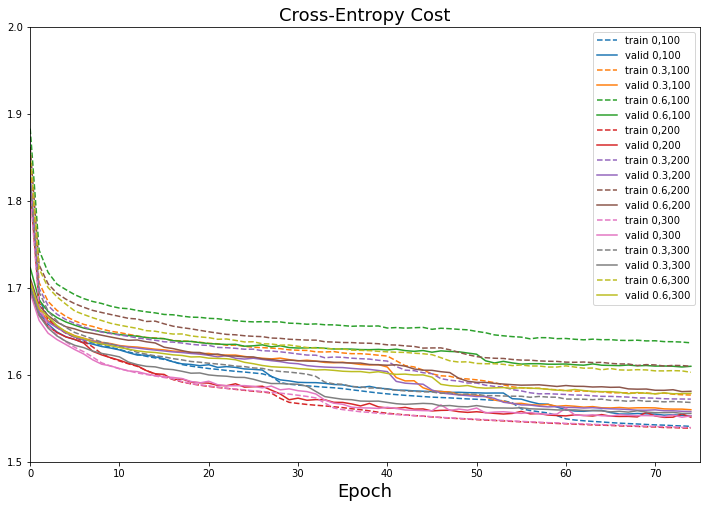

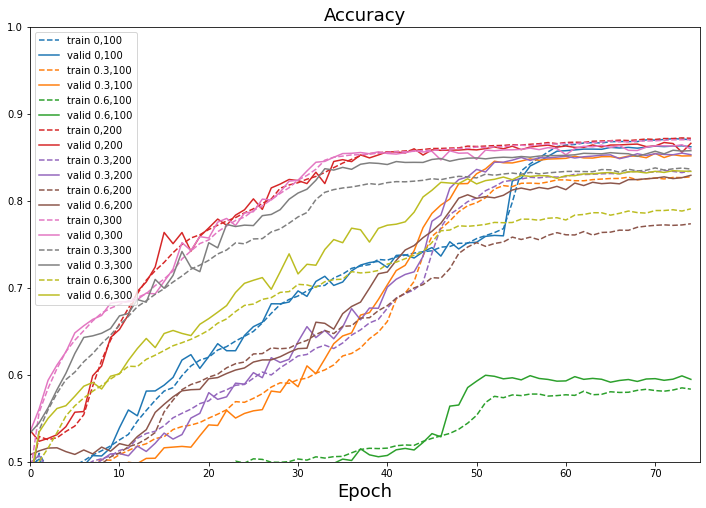

In [23]:
plt.figure(1, figsize=(12,8))
for ic, c in enumerate(complexity):
    for ip, p in enumerate(drop_p):
        i = ip + ic * len(complexity)
        plt.plot(torch.arange(nepochs), costs["train"][i], color=f"C{i}", linestyle="--", label=f"train {p},{c}")
        plt.plot(torch.arange(nepochs), costs["valid"][i], color=f"C{i}", label=f"valid {p},{c}")
plt.xlabel("Epoch", fontsize=18)
plt.xlim(0, nepochs)
plt.ylim(1.5, 2)
plt.title("Cross-Entropy Cost", fontsize=18)
plt.legend()
plt.figure(2, figsize=(12,8))
for ic, c in enumerate(complexity):
    for ip, p in enumerate(drop_p):
        i = ip + ic * len(complexity)
        plt.plot(torch.arange(nepochs), accs["train"][i], color=f"C{i}", linestyle="--", label=f"train {p},{c}")
        plt.plot(torch.arange(nepochs), accs["valid"][i], color=f"C{i}", label=f"valid {p},{c}")
plt.xlabel("Epoch", fontsize=18)
plt.xlim(0, nepochs)
plt.ylim(0.5, 1.0)
plt.title("Accuracy", fontsize=18)
plt.legend()
plt.show()

# Variance

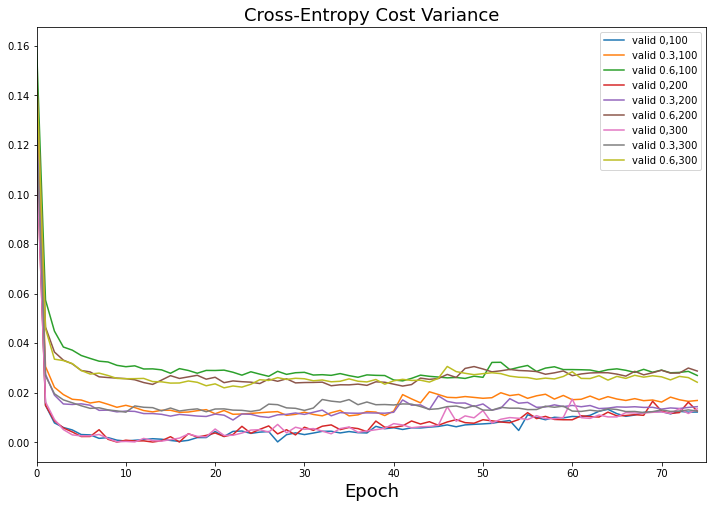

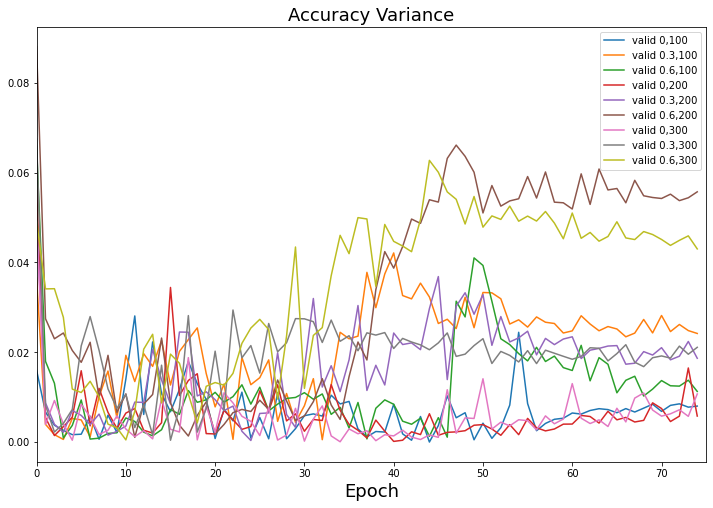

In [24]:
plt.figure(1, figsize=(12,8))
for ic, c in enumerate(complexity):
    for ip, p in enumerate(drop_p):
        i = ip + ic * len(complexity)
        plt.plot(torch.arange(nepochs), abs(np.array(costs["valid"][i]) - np.array(costs["train"][i])),
                 color=f"C{i}", label=f"valid {p},{c}")
plt.xlabel("Epoch", fontsize=18)
plt.xlim(0, nepochs)
plt.title("Cross-Entropy Cost Variance", fontsize=18)
plt.legend()
plt.figure(2, figsize=(12,8))
for ic, c in enumerate(complexity):
    for ip, p in enumerate(drop_p):
        i = ip + ic * len(complexity)
        plt.plot(torch.arange(nepochs), abs(np.array(accs["valid"][i]) - np.array(accs["train"][i])),
                 color=f"C{i}", label=f"valid {p},{c}")
plt.xlabel("Epoch", fontsize=18)
plt.xlim(0, nepochs)
plt.title("Accuracy Variance", fontsize=18)
plt.legend()
plt.show()

In [25]:
nbatch = 64
nepochs = 40
lr = 0.5
fav_model = get_model(complexity=300, drop_p_in=0.3, drop_p_hidden=0.3)
res = train_eval(fav_model, lr, nepochs, nbatch, training_data, validation_data)

Epoch	 Train Costs	 Test Costs	 Train Accuracy	 Test Accuracy
 0	 1.82		 1.70		 0.47		 0.51
 1	 1.70		 1.67		 0.53		 0.55
 2	 1.67		 1.65		 0.55		 0.56
 3	 1.66		 1.64		 0.57		 0.58
 4	 1.65		 1.64		 0.59		 0.60
 5	 1.65		 1.63		 0.60		 0.63
 6	 1.64		 1.63		 0.61		 0.61
 7	 1.64		 1.63		 0.62		 0.63
 8	 1.64		 1.63		 0.63		 0.64
 9	 1.64		 1.62		 0.65		 0.65
10	 1.63		 1.62		 0.66		 0.66
11	 1.63		 1.62		 0.67		 0.68
12	 1.63		 1.61		 0.68		 0.67
13	 1.62		 1.61		 0.68		 0.68
14	 1.62		 1.61		 0.69		 0.70
15	 1.62		 1.61		 0.70		 0.72
16	 1.62		 1.60		 0.71		 0.70
17	 1.62		 1.60		 0.71		 0.73
18	 1.62		 1.60		 0.72		 0.75
19	 1.61		 1.60		 0.73		 0.74
20	 1.61		 1.60		 0.73		 0.75
21	 1.61		 1.60		 0.73		 0.74
22	 1.61		 1.60		 0.74		 0.76
23	 1.61		 1.60		 0.74		 0.76
24	 1.61		 1.60		 0.74		 0.76
25	 1.61		 1.59		 0.74		 0.76
26	 1.61		 1.59		 0.75		 0.76
27	 1.61		 1.59		 0.75		 0.77
28	 1.60		 1.59		 0.75		 0.78
29	 1.60		 1.59		 0.76		 0.78
30	 1.60		 1.59		 0.77		 0.79
31	 1.60

In [26]:
test_loader = DataLoader(test_data, batch_size=nbatch, shuffle=True)
fav_model.eval()
correct = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        predictions = fav_model(inputs)
        correct += (torch.argmax(predictions, dim=1) == targets).sum()
test_acc = correct / len(test_loader.dataset)
test_acc

tensor(0.8121)

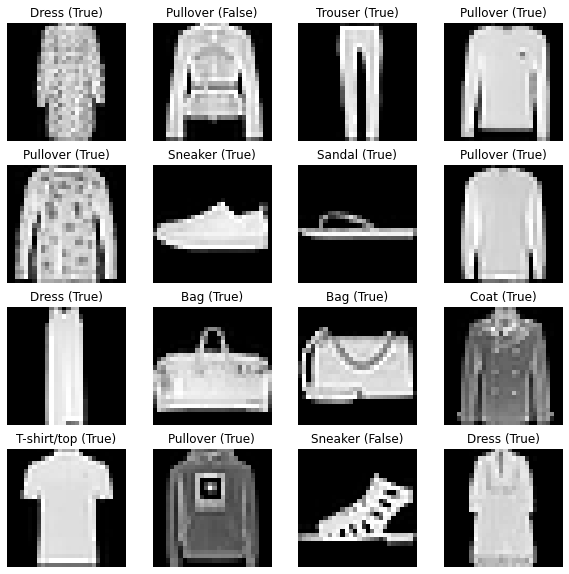

In [34]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    img, label = training_data[np.random.randint(0,len(training_data))]
    figure.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    prediction = fav_model(img).argmax()
    plt.title(f"{training_data.dataset.classes[fav_model(img).argmax()]} ({prediction == label})" )
    plt.axis("off")

# Exercise 3: 5-Fold Cross Validation

In [35]:
from sklearn.model_selection import KFold
cross_val_training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())

In [36]:
nbatch = 64
nepochs = 40
lr = 0.5
k = 5
kf = KFold(n_splits=k, shuffle=True)
cross_val_acc_hists = []
for train_idx, valid_idx in kf.split(cross_val_training_data):
    model = get_model(complexity=300, drop_p_in=0.3, drop_p_hidden=0.3)
    _, _, _, cross_val_acc_hist = train_eval(
        model, lr, nepochs, nbatch, cross_val_training_data, training_sampler=train_idx, validation_sampler=valid_idx)
    cross_val_acc_hists.append(cross_val_acc_hist)

Epoch	 Train Costs	 Test Costs	 Train Accuracy	 Test Accuracy
 0	 1.83		 1.70		 0.46		 0.53
 1	 1.70		 1.67		 0.53		 0.56
 2	 1.68		 1.66		 0.55		 0.57
 3	 1.66		 1.65		 0.56		 0.59
 4	 1.66		 1.64		 0.58		 0.60
 5	 1.65		 1.64		 0.59		 0.61
 6	 1.65		 1.63		 0.60		 0.63
 7	 1.64		 1.63		 0.61		 0.64
 8	 1.64		 1.63		 0.62		 0.64
 9	 1.64		 1.62		 0.63		 0.65
10	 1.63		 1.62		 0.64		 0.66
11	 1.63		 1.62		 0.65		 0.66
12	 1.63		 1.62		 0.66		 0.67
13	 1.63		 1.61		 0.67		 0.68
14	 1.62		 1.61		 0.68		 0.68
15	 1.62		 1.61		 0.69		 0.69
16	 1.62		 1.61		 0.70		 0.71
17	 1.62		 1.61		 0.70		 0.71
18	 1.62		 1.60		 0.71		 0.72
19	 1.62		 1.60		 0.72		 0.74
20	 1.62		 1.60		 0.73		 0.74
21	 1.61		 1.60		 0.73		 0.75
22	 1.61		 1.60		 0.74		 0.76
23	 1.61		 1.60		 0.74		 0.76
24	 1.61		 1.60		 0.75		 0.77
25	 1.61		 1.60		 0.75		 0.78
26	 1.61		 1.60		 0.76		 0.77
27	 1.61		 1.60		 0.76		 0.77
28	 1.61		 1.59		 0.76		 0.78
29	 1.61		 1.59		 0.77		 0.79
30	 1.61		 1.59		 0.77		 0.80
31	 1.60

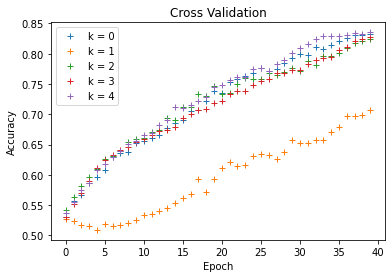

In [41]:
plt.figure()
for i in range(k):
    plt.plot(torch.arange(nepochs), cross_val_acc_hists[i], "+", label=f"k = {i}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Cross Validation")
plt.show()